# Analysis of Looping Structure of Neural Embeddings


## Setup

In [86]:
pip install numpy matplotlib hdbscan scipy

In [87]:
# Libaries
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
import scipy

In [88]:
# Mount Drive to access files on google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Extracting Subsequences

In [89]:
# Load a file
data = np.load('/content/drive/MyDrive/Pk146-Jul28/3B.npz')

emb = data['embVals']
neuralArr = data['neuroArr']
vocalArr = data['behavioralArr']
embStartEnd = data['embStartEnd']
startTimes = embStartEnd[0,:]

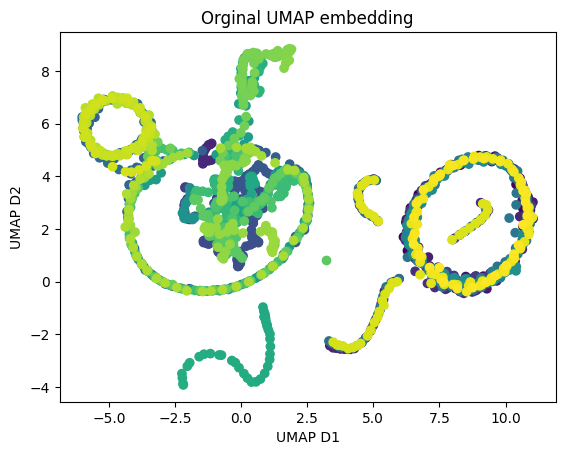

In [90]:
plt.title('Orginal UMAP embedding')
plt.scatter(emb[:,0],emb[:,1],c = startTimes)
plt.xlabel('UMAP D1')
plt.ylabel('UMAP D2')
plt.show()

<ipython-input-102-f5c6266ed4a2>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,1,1)


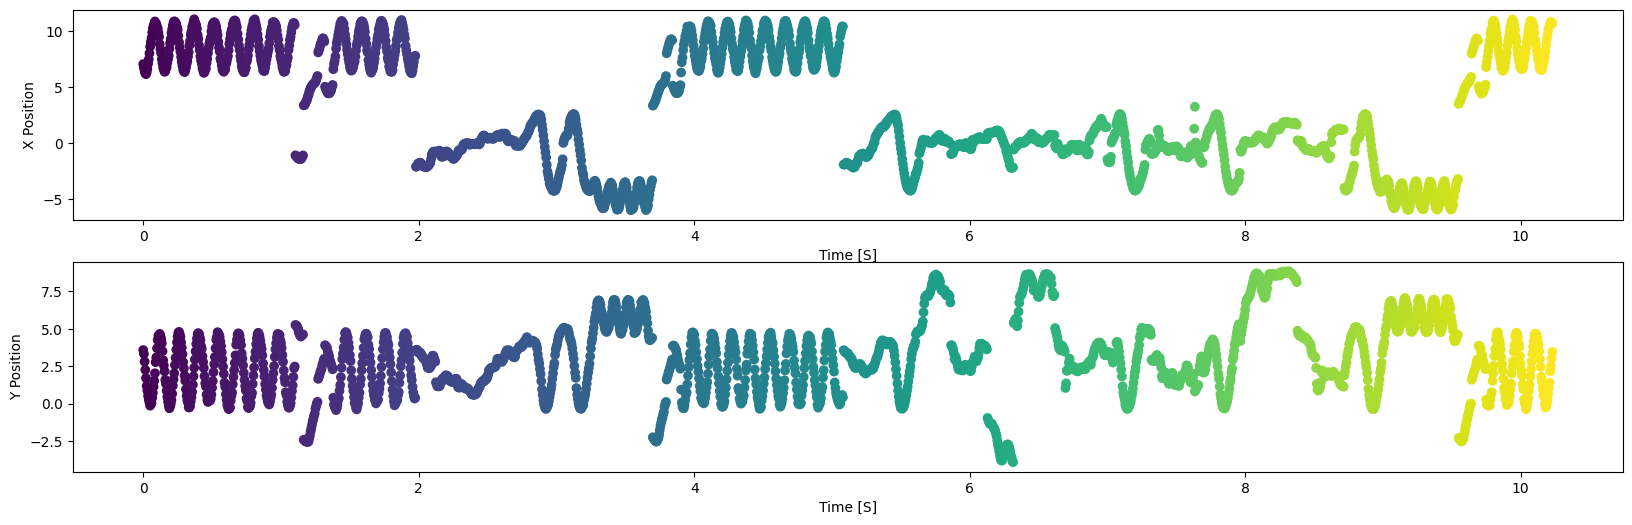

In [102]:
fig = plt.figure(figsize=(20, 6))

plt.title('X and Y Coordinate of UMAP embedding')
plt.subplot(2,1,1)
plt.scatter(startTimes,emb[:,0],c = startTimes)
plt.xlabel('Time [S]')
plt.ylabel('X Position')
plt.ylabel('X Position')
plt.subplot(2,1,2)
plt.scatter(startTimes,emb[:,1],c = startTimes)
plt.xlabel('Time [S]')
plt.ylabel('Y Position')

plt.show()

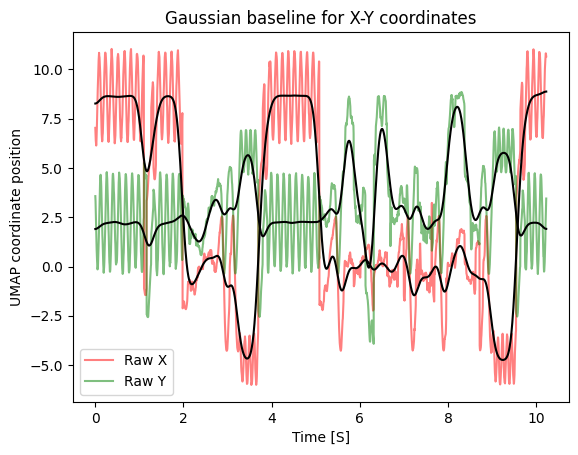

In [92]:
from scipy.ndimage import gaussian_filter1d


rawX = emb[:,0]
rawY = emb[:,1]

M = 20
BLX = gaussian_filter1d(rawX, M) #np.convolve(rawY, np.ones(M)/M, mode='same')#np.convolve(rawX, np.ones(M)/M, mode='same')
BLY = gaussian_filter1d(rawY, M) #np.convolve(rawY, np.ones(M)/M, mode='same')
BCX = rawX - BLX
BCY = rawY - BLY

plt.title('Gaussian baseline for X-Y coordinates')
plt.plot(startTimes,rawX,color = 'r', label = 'Raw X',alpha = .5)
plt.plot(startTimes,rawY,color = 'g',label = 'Raw Y',alpha = .5)
plt.plot(startTimes,BLX,color = 'k')
plt.plot(startTimes,BLY,color = 'k')
plt.xlabel('Time [S]')
plt.ylabel('UMAP coordinate position')
plt.legend()
plt.show()


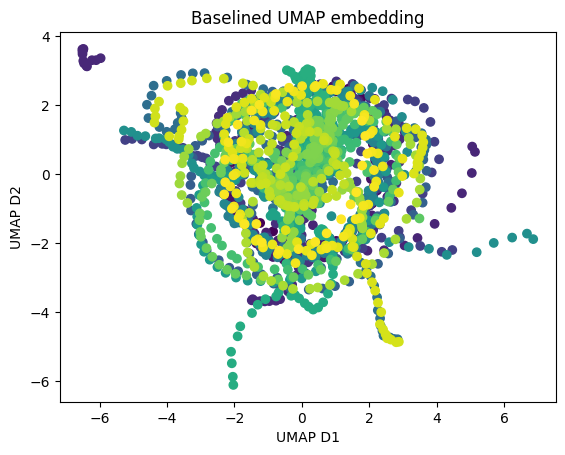

In [93]:
plt.title('Baselined UMAP embedding')
plt.scatter(BCX,BCY,c = startTimes)
plt.xlabel('UMAP D1')
plt.ylabel('UMAP D2')
plt.show()

In [94]:
# Calc running polar
naiveTheta = np.arctan2(BCY, BCX)
radiusArr = np.sqrt(np.square(BCX) + np.square(BCY))
angleCuttoff = -6

modTheta = naiveTheta.copy()
modTheta[0] = naiveTheta[0]
for i in range(1,len(naiveTheta)):
  angleDiff = naiveTheta[i] - naiveTheta[i-1]
  if angleDiff < angleCuttoff:
    modTheta[i] = modTheta[i-1] + angleDiff + 2*np.pi
  else:
    modTheta[i] =  modTheta[i-1] + angleDiff

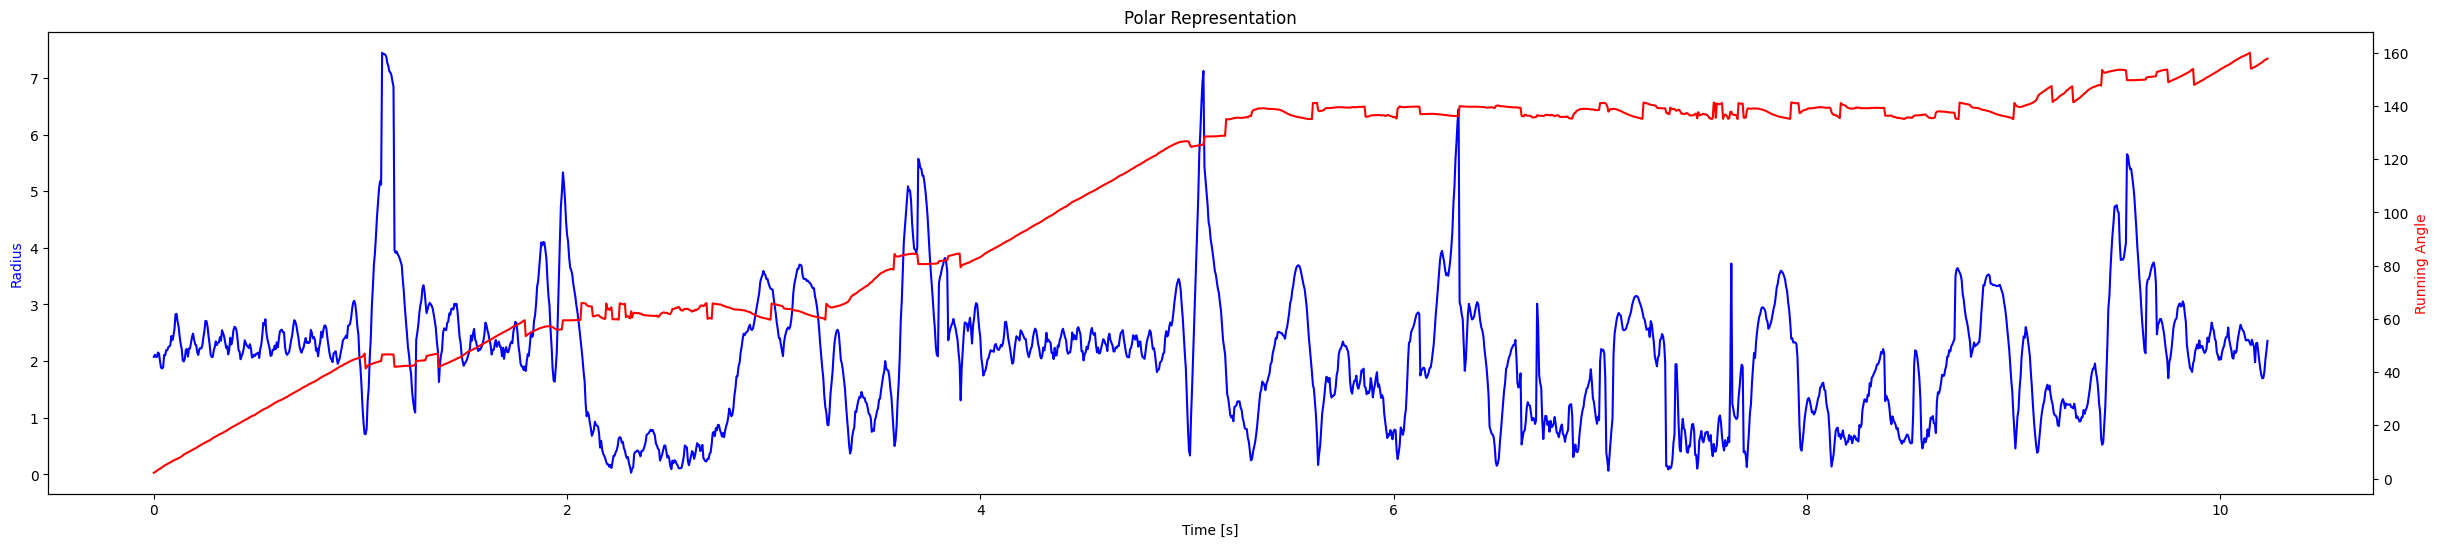

In [95]:
# Display Polar
fig, ax1 = plt.subplots(figsize=(30, 6))

plt.title('Polar Representation')
ax1.plot(startTimes,radiusArr, color='blue')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Radius', color='blue')

ax2 = ax1.twinx()
ax2.plot(startTimes, modTheta, color='red')
ax2.set_ylabel('Running Angle', color='red')

plt.show()


In [96]:
# Revise w/ min length
def find_subarrays(arr, polarity):
    subarrays = []
    start = 0

    for end in range(1, len(arr)):
        if polarity * arr[end] > polarity * arr[end - 1]:
            continue
        if start < end - 1:
            subarrays.append((start, end - 1))
        start = end

    if start < len(arr) - 1:
        subarrays.append((start, len(arr) - 1))

    return subarrays


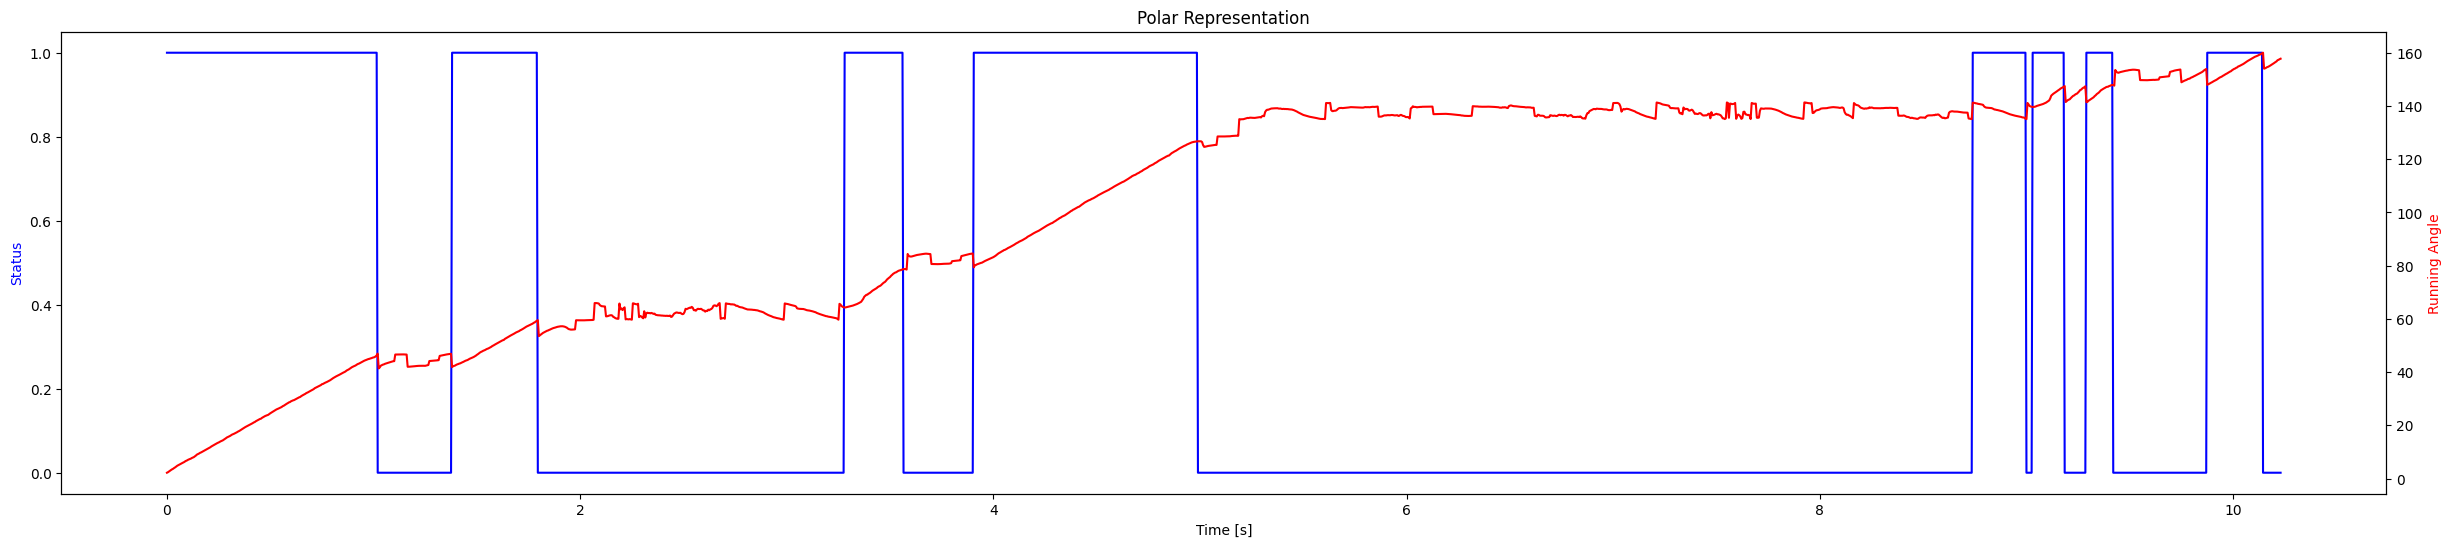

In [97]:
# Calculate monotonic periods of increasing and decreasing
increasing_subarrays_corrected_theta = find_subarrays(modTheta,1)
decreasing_subarrays_corrected_theta = find_subarrays(modTheta,-1)

additiveArr = increasing_subarrays_corrected_theta + decreasing_subarrays_corrected_theta
embCentered = emb.copy()

timeInd = np.arange(len(startTimes))
statusArr = np.zeros_like(startTimes)

cutoffAngle = 5
cutoffLength = 20

validLoops = list()
for start,end in additiveArr:
  diffAngle = modTheta[end] - modTheta[start]
  if np.abs(diffAngle) > cutoffAngle and end - start > cutoffLength: #todo pi
    statusArr[start:end] = 1
    validLoops.append((start,end))

    randLength = end - start
    randNoise1 = np.random.normal(0, .1, randLength)
    randNoise2 = np.random.normal(0, .1, randLength)
    #print(randNoise)
    embCentered[start:end,0] = np.mean(emb[start:end,0]) + randNoise1
    embCentered[start:end,1] = np.mean(emb[start:end,1]) + randNoise2


# Display Polar
fig, ax1 = plt.subplots(figsize=(30, 6))

plt.title('Polar Representation')
ax1.plot(startTimes,statusArr, color='blue')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Status', color='blue')

ax2 = ax1.twinx()
ax2.plot(startTimes, modTheta, color='red')
ax2.set_ylabel('Running Angle', color='red')

plt.show()


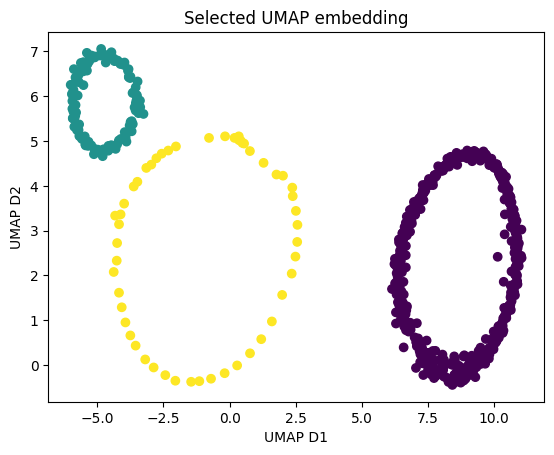

In [98]:
#HDBSCAN

def makeClusters(data,min_cluster_size = 10):
	clusterer = hdbscan.HDBSCAN(metric='euclidean',min_cluster_size=min_cluster_size)
	clusterer.fit(data)
	return clusterer.labels_

statusOne = np.where(statusArr == 1)[0]

labels = makeClusters(embCentered[statusOne,:])

plt.title('Selected UMAP embedding')
plt.scatter(emb[statusOne,0],emb[statusOne,1],c = labels)
plt.xlabel('UMAP D1')
plt.ylabel('UMAP D2')
plt.show()

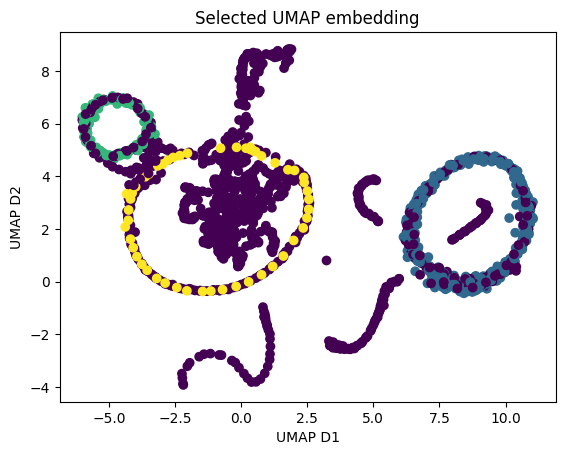

In [99]:

classArr = np.zeros_like(statusArr)
classArr[statusOne] = labels + 1


plt.title('Selected UMAP embedding')
plt.scatter(emb[:,0],emb[:,1],c = classArr)
plt.xlabel('UMAP D1')
plt.ylabel('UMAP D2')
plt.show()

In [100]:
# Now get angles

# masterOutput = dict()
# for index in np.unique(classArr):
#   name = f'Loop{int(index)}'
#   masterOutput[name] = list()
#   print(name)

for start,end in validLoops:
  classFound = np.median(classArr[start:end])
  diffAngle = modTheta[end] - modTheta[start]
  loopNum = diffAngle/(2*np.pi)
  name = f'Loop{int(classFound)}'

  print(f'Loop{classFound} found with {loopNum} loops')

#   try:
#     masterOutput[name] = masterOutput[name].append(loopNum)
#   except:
#     masterOutput[name] = [loopNum]

# masterOutput




Loop1.0 found with 7.126143391697145 loops
Loop1.0 found with 2.802875891121637 loops
Loop2.0 found with 2.306225212249367 loops
Loop1.0 found with 7.538964882156126 loops
Loop2.0 found with 1.2526117663137981 loops
Loop2.0 found with 1.0280278608686642 loops
Loop1.0 found with 1.9263974818130682 loops
Loop3.0 found with -0.9857984708322723 loops
